In [1]:
import clip
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

In [2]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
import logging
# Set Logger
logger = logging.getLogger('notebook_logger')
logger.setLevel(logging.DEBUG)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Define Data Loader

In [4]:
# Showing one example
# TODO: Add VSNR for cosine similarity
data_loader = loaders.DataLoader(data_source = "qa", logger=logger)
df_table = data_loader.load_dialogue_df()

#k = 5
#data_loader.showing_example(k)
#data_loader.show_clip_similarity(k, df_table, model, preprocess)

# Define OOD Categories below

In [5]:
ood_category = ['vehicle']
ind_category = [x for x in data_loader.supercategories if x not in ood_category]
df_table['OOD'] = df_table['supercategory'].apply(lambda x: 0 if any(item in x for item in ind_category) else 1)
df_table['OOD'].value_counts()

OOD
0    116167
1      6051
Name: count, dtype: int64

# Load CLIP features for images and dialogues with Model CLIP ViT-B32

In [6]:
if data_loader.data_source == "real":
    ## Dialogue Processing
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_truncate/mmd_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)

    ## Image Processing
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_imgs_filenames.json')
    image_annotation = image_annotation.rename(columns={0:"img_file"}).join(pd.DataFrame(pd.DataFrame(image_clip.tolist()).apply(np.array, axis=1)))
    image_annotation.rename(columns={0:"image_clip"}, inplace=True)
    df_table = df_table.merge(image_annotation, on='img_file', how='left')

elif data_loader.data_source == "qa":
    ## Dialogue Processing
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/qa_dialogs_truncate/qa_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)

    ## Image Processing
    df_table['image_file'] = df_table['image_id'].astype('str') + '.jpg'
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/qa_imgs/qa_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/qa_imgs/all_img_names.json')
    image_annotation = image_annotation.rename(columns={0:"image_file"})
    image_annotation['image_clip'] = list(image_clip)
    df_table = df_table.merge(image_annotation, on='image_file', how='left') 

    

In [7]:
#dialogue_df_segment = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_expand_dialog.json')
#dialogue_clip_segment = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_dialog_features.npy')
#dialogue_df_segment['dialogue_clip'] = list(dialogue_clip_segment)

In [8]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategory']))
encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)
df_table = pd.concat([df_table, encoded_df], axis=1)

In [9]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()

#if data_loader.data_source == "qa":
#    df_table['image_id'] = df_table['image_id'].apply(lambda x: f"COCO_train2014_{int(x):012d}")

categories_clip = {}
for categories in ind_category:
    text = 'Category ' + categories
    text_tokens = clip.tokenize([text]).to(device)  
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).flatten().cpu().numpy()
        categories_clip[categories] = text_features

def calculate_similarity_score(row, type = "image"):
    if type == "image":
        column = 'image_clip'
    elif type == "dialogue":
        column = 'dialogue_clip'

    cosine_sim = 0
    cosine_sim_max = 0
    for categories in ind_category:
        text_features = categories_clip[categories]
        cosine_sim_current = np.dot(text_features, row[column]) / (np.linalg.norm(text_features) * np.linalg.norm(row[column]))
        cosine_sim += cosine_sim_current
        cosine_sim_max = max(cosine_sim_max, cosine_sim_current)


    return cosine_sim, cosine_sim_max

df_table['image_score'], df_table['image_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1))
#dialogue_df_segment['dialogue_score'], dialogue_df_segment['dialogue_score_max'] = zip(*dialogue_df_segment.progress_apply(calculate_similarity_score, type = "dialogue", axis=1))
df_table['dialogue_score'], df_table['dialogue_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1, args=('dialogue',)))

  0%|          | 0/122218 [00:00<?, ?it/s]

  0%|          | 0/122218 [00:00<?, ?it/s]

In [ ]:
#df_table['dialogue_score_segment'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score'].mean())['dialogue_score'].values
#df_table['dialogue_score_segment_max'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score_max'].mean())['dialogue_score_max'].values

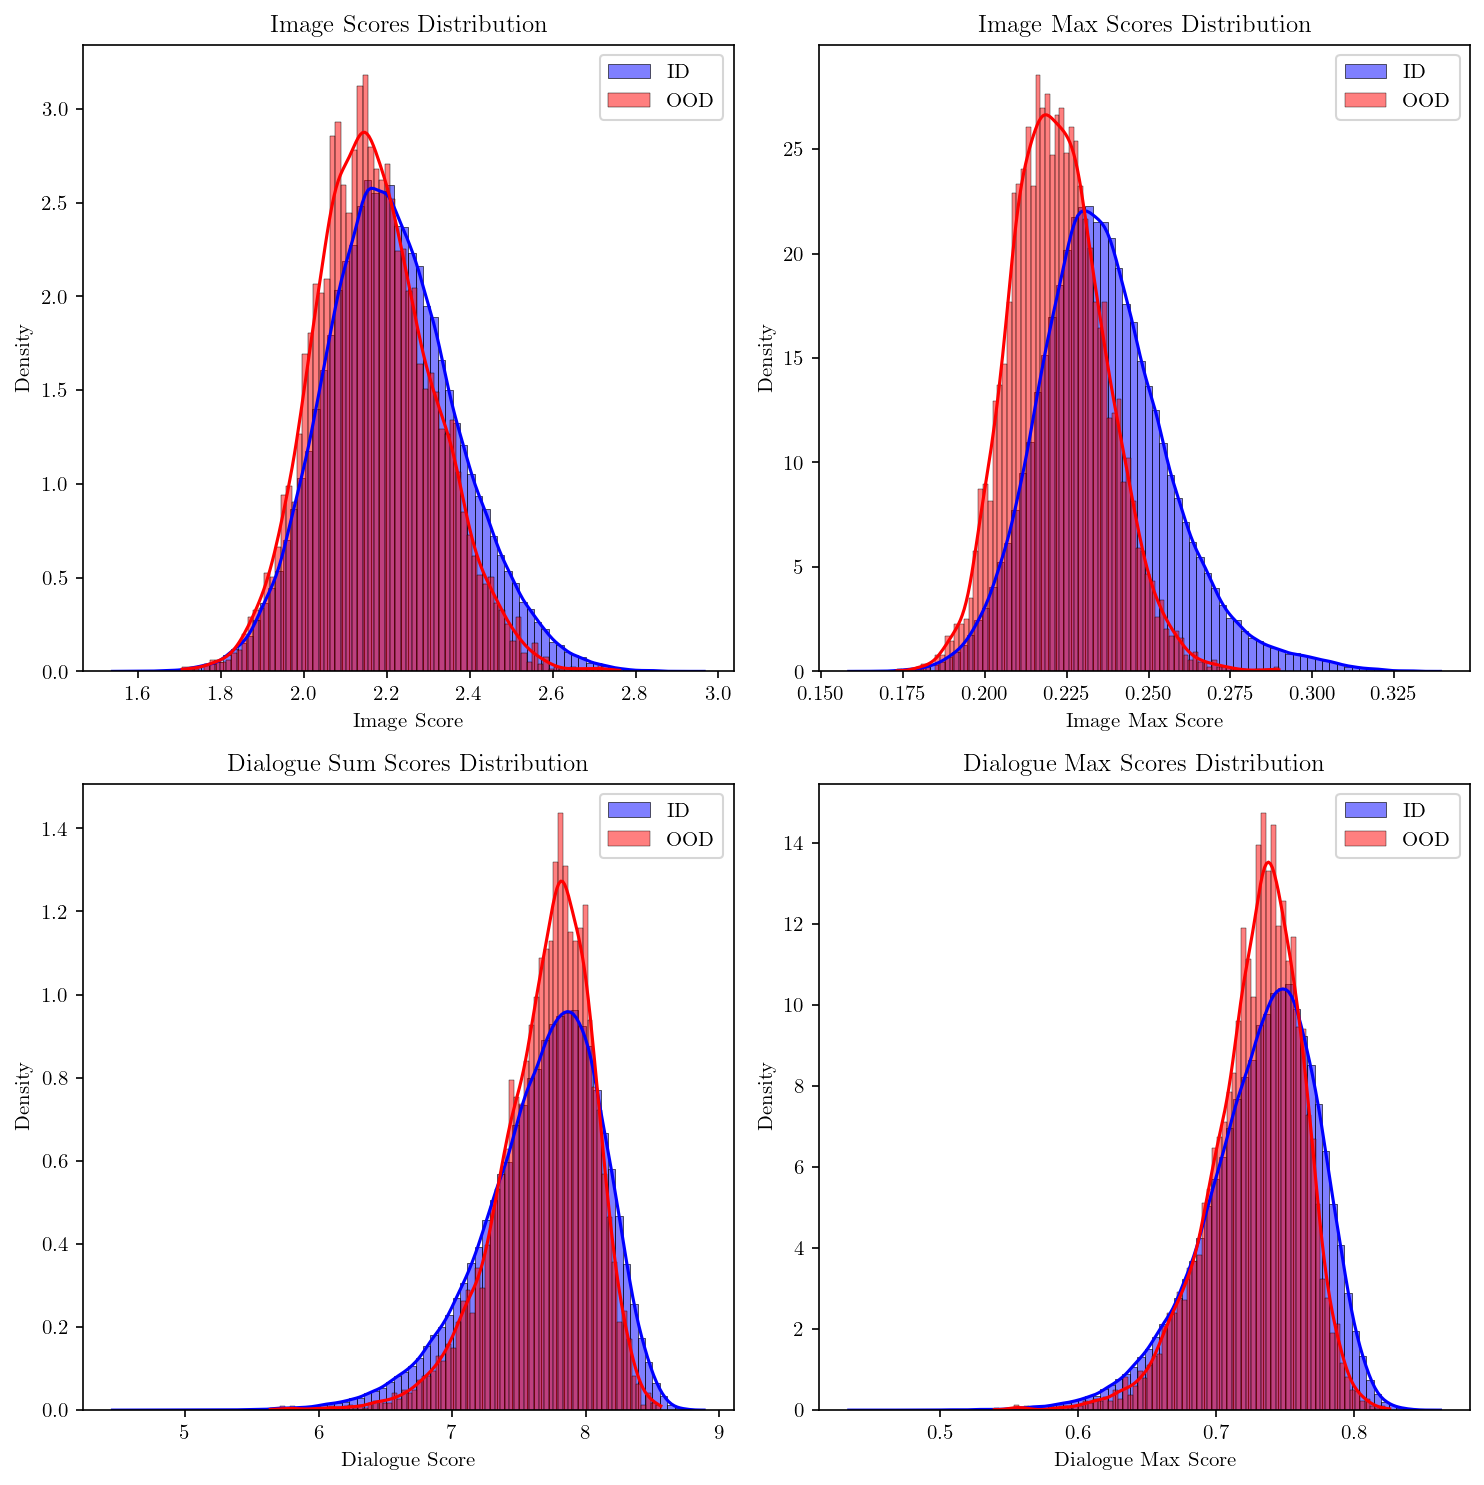

In [10]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
plt.rcParams['figure.dpi'] = 150 
# Assuming df_table is preloaded with the appropriate columns
# Simplifying the code and plotting all histograms in a 2x2 layout

# Create figure and axes for a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Data for histograms
columns = ['image_score', 'image_score_max', 'dialogue_score', 'dialogue_score_max'] #'dialogue_score_segment', 'dialogue_score_segment_max']
titles = ['Image Scores Distribution', 'Image Max Scores Distribution',
          'Dialogue Sum Scores Distribution', 'Dialogue Max Scores Distribution']
         #'Dialogue Segment Sum Scores Distribution', 'Dialogue Segment Max Scores Distribution']
x_labels = ['Image Score', 'Image Max Score', 'Dialogue Score', 'Dialogue Max Score'] # 'Dialogue Segment Score', 'Dialogue Segment Max Score']

# Loop through to plot each histogram in its subplot
for i, ax in enumerate(axs.flatten()):
    ood_scores = df_table[df_table['OOD'] == 1][columns[i]]
    non_ood_scores = df_table[df_table['OOD'] == 0][columns[i]]
    sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue', ax=ax, stat="density")
    sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red', ax=ax, stat="density")
    ax.legend(loc='upper right')
    ax.set_title(titles[i])
    ax.set_xlabel(x_labels[i])
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

In [11]:
import importlib
importlib.reload(ev)

<module 'utils.evaluation' from 'f:\\Github\\multimodal_ood\\utils\\evaluation.py'>

In [12]:
def image_text_similarity(row):
    a = row['dialogue_clip']
    b = row['image_clip']
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim
df_table['image_text_similarity'] = df_table.apply(image_text_similarity, axis=1)
df_table['overall_simialrity'] = df_table['image_text_similarity'] * (df_table['image_score_max'] + 0.001*df_table['dialogue_score_max'])
df_table['overall_simialrity_sum'] = df_table['image_text_similarity'] * (df_table['image_score'] + 0.001*df_table['dialogue_score'])

In [13]:
print('Image Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['image_score_max'].values, 0.95))
print('Image Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['image_score'].values, 0.95))
print('Dialogue Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_max'].values, 0.95))
print('Dialogue Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score'].values, 0.95))
#print('Dialogue Segment Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment_max'].values, 0.95))
#print('Dialogue Segment Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment'].values, 0.95))
print("Overall Max:", ev.fpr_evaluation(df_table['OOD'].values, -df_table['overall_simialrity'].values, 0.95))
print("Overall Sum:", ev.fpr_evaluation(df_table['OOD'].values, -df_table['overall_simialrity_sum'].values, 0.95))

Image Max: 0.7420265652035432
Image Sum: 0.8902872588600893
Dialogue Max: 0.865064949598423
Dialogue Sum: 0.8948754809885768
Overall Max: 0.8222817151170297
Overall Sum: 0.8969414721908976


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from models.DNN import model 

image_model_loader = model.model_loader(logger=logger,
                                  num_epochs=15)

dialogue_model_loader = model.model_loader(logger=logger,
                                    num_epochs=15,
                                    learning_rate=0.001)

2024-05-10 14:02:33,664 - notebook_logger - INFO - Setting random seed: 42
2024-05-10 14:02:33,666 - notebook_logger - INFO - Setting random seed: 42


In [15]:
(
    df_ind_train, 
    df_test, 
    X_train_image, 
    X_test_image, 
    X_train_dialogue, 
    X_test_dialogue, 
    Y_train, 
    Y_test) = image_model_loader.create_dataset(data_loader, df_table)


In [16]:
image_model_loader.train_model(X_train_image, Y_train)

100%|██████████| 15/15 [02:37<00:00, 10.51s/it]


In [17]:
dialogue_model_loader.train_model(X_train_dialogue, Y_train)

100%|██████████| 15/15 [02:26<00:00,  9.73s/it]


In [18]:
score_type_list = ["mp", "energy", "maxlogits", "msp"]

for score_type in score_type_list:
    image_score_sum, image_score_max = image_model_loader.evaluate_on_test(X_test_image, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    dialogue_score_sum, dialogue_score_max = dialogue_model_loader.evaluate_on_test(X_test_dialogue, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    df_test[f'{score_type}_sum_image'] = image_score_sum
    df_test[f'{score_type}_max_image'] = image_score_max
    df_test[f'{score_type}_sum_dialogue'] = dialogue_score_sum
    df_test[f'{score_type}_max_dialogue'] = dialogue_score_max
    df_test[f'{score_type}_overall_simialrity'] = df_test['image_text_similarity'] * (df_test[f'{score_type}_max_image'] + df_test[f'{score_type}_max_dialogue'])
    if score_type == "energy":
        df_test[f'{score_type}_overall_simialrity_sum'] = df_test['image_text_similarity'] * (df_test[f'{score_type}_sum_image'] + df_test[f'{score_type}_sum_dialogue'])

2024-05-10 14:07:42,040 - notebook_logger - INFO - Test Loss: 0.1867, Test Accuracy: 0.4796
2024-05-10 14:07:42,668 - notebook_logger - INFO - Test Loss: 0.2328, Test Accuracy: 0.3549
2024-05-10 14:07:43,257 - notebook_logger - INFO - Test Loss: 0.1867, Test Accuracy: 0.4796
2024-05-10 14:07:43,831 - notebook_logger - INFO - Test Loss: 0.2328, Test Accuracy: 0.3549
2024-05-10 14:07:44,468 - notebook_logger - INFO - Test Loss: 0.1867, Test Accuracy: 0.4796
2024-05-10 14:07:45,056 - notebook_logger - INFO - Test Loss: 0.2328, Test Accuracy: 0.3549
2024-05-10 14:07:45,671 - notebook_logger - INFO - Test Loss: 0.1867, Test Accuracy: 0.4796
2024-05-10 14:07:46,297 - notebook_logger - INFO - Test Loss: 0.2328, Test Accuracy: 0.3549


In [19]:
score_type = "mp"

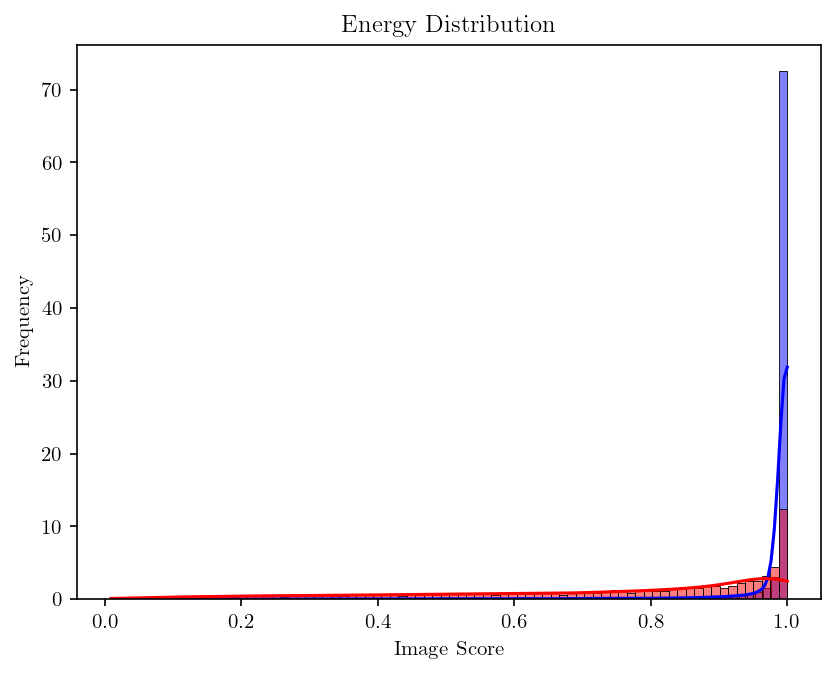

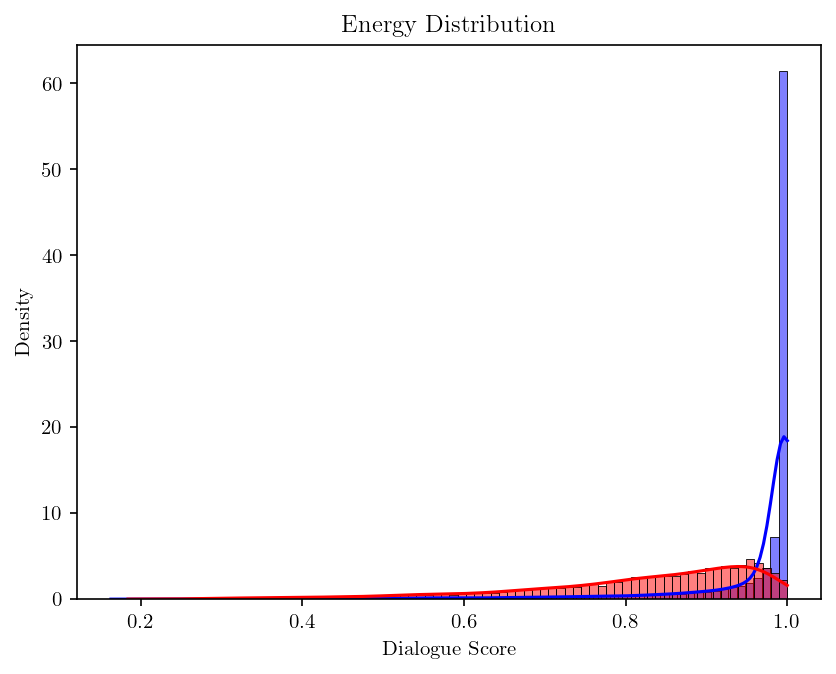

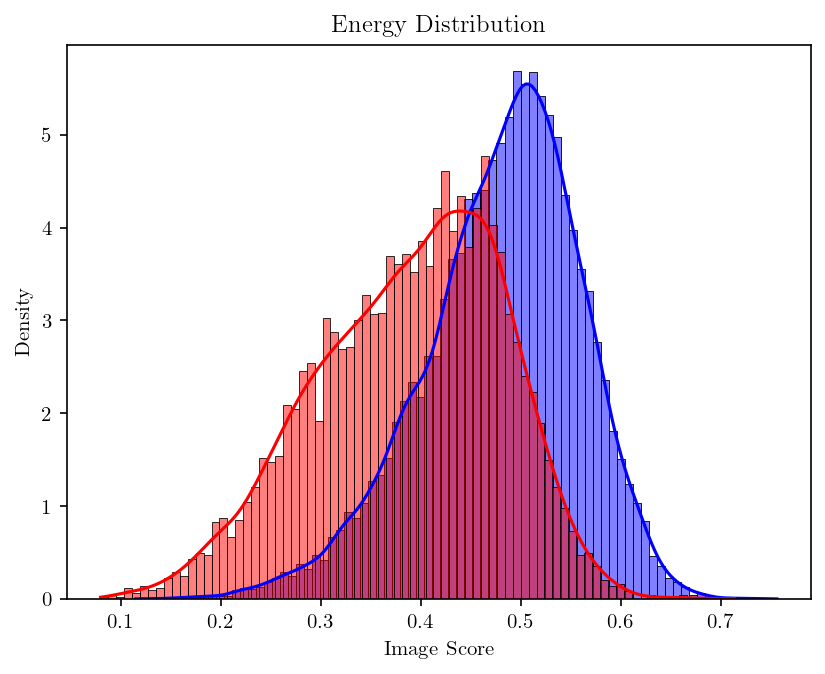

In [23]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_max_image']
non_ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_max_image']

sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue',stat="density")
sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red', stat="density")
plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')
plt.show()


ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_max_dialogue']
non_ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_max_dialogue']

sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue', stat="density")
sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red', stat="density")
plt.title('Energy Distribution')
plt.xlabel('Dialogue Score')
plt.ylabel('Density')
plt.show()

ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_overall_simialrity']
non_ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_overall_simialrity']

sns.histplot(non_ood_scores, bins=80, alpha=0.5, label='ID', kde=True, color='blue',  stat="density")
sns.histplot(ood_scores, bins=80, alpha=0.5, label='OOD', kde=True, color='red',  stat="density")
plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Density')

plt.show()

In [21]:
# Initialize lists to store data
metrics = []
values = []
scores = [] 

def eval_dict(score):
    return {
        "FPR": lambda x: ev.fpr_evaluation(x['OOD'].values, -x[score].values, 0.95),
        "AUROC": lambda x: ev.auroc_evaluation(x['OOD'].values, -x[score].values),
        "AUPR": lambda x: ev.aupr_evaluation(x['OOD'].values, -x[score].values)
    }

# Define the metrics and corresponding functions
metric_functions = {
    "Max Cosine": {
        "Image": eval_dict('image_score_max'),
        "Dialogue": eval_dict('dialogue_score_max'),
        "Overall": eval_dict('overall_simialrity')
    },
    "Sum Cosine": {
        "Image": eval_dict('image_score'),
        "Dialogue": eval_dict('dialogue_score'),
        "Overall": eval_dict('overall_simialrity_sum')
    },
    "Energy Sum": {
        "Image": eval_dict('energy_sum_image'),
        "Dialogue": eval_dict('energy_sum_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_sum')
    },
    "Energy Max": {
        "Image": eval_dict('energy_max_image'),
        "Dialogue": eval_dict('energy_max_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity')
    },
    "MSP": {
        "Image": eval_dict('msp_max_image'),
        "Dialogue": eval_dict('msp_max_dialogue'),
        "Overall": eval_dict('msp_overall_simialrity')
    },
    "Max Prob": {
        "Image": eval_dict('mp_max_image'),
        "Dialogue": eval_dict('mp_max_dialogue'),
        "Overall": eval_dict('mp_overall_simialrity')
    },
    "Max Logits": {
        "Image": eval_dict('maxlogits_max_image'),
        "Dialogue": eval_dict('maxlogits_max_dialogue'),
        "Overall": eval_dict('maxlogits_overall_simialrity')
    }
}

# Loop through each metric and calculate values
for score, items in metric_functions.items():
    scores.extend([score] * len(items) * 3)
    for metric, funcs in items.items():
        metrics.extend([metric] * len(funcs))
        values.extend([func(df_test) for func in funcs.values()])

# Create DataFrame
df = pd.DataFrame({"Metric": metrics, "Value": values, "Score": scores})
df['Value'] = df['Value'].apply(lambda x: round(x, 3))
#df_grouped = df.groupby('Metric')['Value'].apply(list).reset_index()
result = df.groupby(['Metric', 'Score'])['Value'].agg(list).unstack().transpose()
result[['Image', 'Dialogue', 'Overall']]

Metric,Image,Dialogue,Overall
Score,,,
Energy Max,"[0.293, 0.927, 0.762]","[0.289, 0.873, 0.512]","[0.223, 0.938, 0.759]"
Energy Sum,"[0.171, 0.953, 0.813]","[0.183, 0.921, 0.633]","[0.125, 0.963, 0.83]"
MSP,"[0.781, 0.68, 0.346]","[0.672, 0.68, 0.291]","[0.859, 0.596, 0.271]"
Max Cosine,"[0.738, 0.712, 0.345]","[0.867, 0.539, 0.208]","[0.819, 0.583, 0.228]"
Max Logits,"[0.293, 0.927, 0.762]","[0.289, 0.873, 0.512]","[0.223, 0.939, 0.769]"
Max Prob,"[0.293, 0.927, 0.762]","[0.289, 0.873, 0.512]","[0.696, 0.775, 0.498]"
Sum Cosine,"[0.886, 0.578, 0.241]","[0.895, 0.493, 0.19]","[0.893, 0.514, 0.198]"
